In [1]:
%matplotlib inline

In [49]:
# coding: utf-8


import os
import numpy as np
import pickle as pkl
import argparse
from tqdm import tqdm
from joblib import Parallel, delayed
from copy import copy
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
    
from helpers import load_cascades
from graph_helpers import load_graph_by_name

np.seterr(divide='raise', invalid='raise')


parser = argparse.ArgumentParser(description='')
parser.add_argument('-g', '--graph', help='graph name')
parser.add_argument('-c', '--cascade_pattern', help='cascade pattern')
parser.add_argument('-n', '--n_queries', type=int, help='number of queries to show')
parser.add_argument('-s', '--sampling_method', help='')
parser.add_argument('-i', '--inf_method', help='')

args = parser.parse_args()

inf_result_dirname = 'outputs/{}/{}/{}'.format(args.inf_method, args.cascade_pattern, args.sampling_method)
query_dirname = 'outputs/queries/{}/{}'.format(args.cascade_pattern, args.sampling_method)

# if n_queries is too large, e.g, 100, we might have no hidden infected nodes left and average precision score is undefined
n_queries = args.n_queries

g = load_graph_by_name(graph_name)

methods = ['pagerank', 'random', 'entropy', 'prediction_error']


usage: ipykernel_launcher.py [-h] [-g GRAPH] [-c CASCADE_PATTERN]
                             [-n N_QUERIES] [-s SAMPLING_METHOD]
                             [-i INF_METHOD]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-661fb856-cf44-4940-a696-3860c3308a3c.json


SystemExit: 2

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [44]:

cascades = load_cascades('cascade/' + cascade_pattern)

scores_by_method = {}
for method in methods:
    scores_by_method[method] = []

# scores_by_method: key to [n_experiments x n_queries]

c_paths = []  # track the order
for c_path, (obs, c) in tqdm(cascades):
    
    obs = set(obs)
    c_paths.append(c_path)
    infected = (c >= 0).nonzero()[0]
    infected_set = set(infected)
    # print('infection size', len(infected_set))
    # labels for nodes, 1 for infected, 0 for uninfected
    y_true = np.zeros((len(c), ))
    y_true[infected] = 1
    
    for method in methods:

        cid = os.path.basename(c_path).split('.')[0]
        inf_probas_path = os.path.join(
            inf_result_dirname,
            method,
            '{}.pkl'.format(cid))
        inf_probas_list = pkl.load(open(inf_probas_path, 'rb'))
                
        query_path = os.path.join(
            query_dirname, 
            method, 
            '{}.pkl'.format(cid)
        )
        queries = pkl.load(open(query_path, 'rb'))[0]
        scores = []
        obs_inc = copy(obs)
        for inf_probas, query, _ in zip(inf_probas_list, queries, range(n_queries)):
            obs_inc.add(query)            
            # need to mask out the observations
            # use precision score
            mask = np.array([(i not in obs_inc) for i in range(len(c))])
            try:
                score = average_precision_score(y_true[mask], inf_probas[mask])
            except FloatingPointError:
                # in this case, there is no positive data points left in y_true[mask]
                # therefore, precision is always zero
                
                raise ValueError from FloatingPointError
            scores.append(score)                

        scores_by_method[method].append(scores)

96it [01:06,  1.47it/s]


In [45]:
scores_3d = np.array([scores_by_method[m] for m in methods])

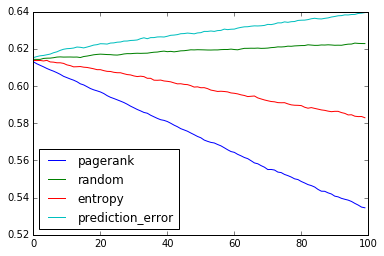

In [47]:

plt.clf()
fig = plt.figure()
for method in methods:
    scores = np.array(scores_by_method[method], dtype=np.float32)
    mean_scores = np.mean(scores, axis=0)
    # print(np.std(scores,axis=0))
    plt.plot(mean_scores)
    plt.hold(True)
plt.legend(methods, loc='best')
fig.savefig('figs/average_precision_score/{}.png'.format(cascade_pattern))